Original sequence: [1. 2. 3. 4. 1. 2. 3. 5. 1. 2. 3. 6.]
Original sequence length: 12

Coefficients after DWT (length 4):
  Approximation coeffs (cA3): [7.42 8.49]
  Detail coeffs (cD3): [-0.35  0.  ]
  Detail coeffs (cD2): [-2.  -2.5 -3. ]
  Detail coeffs (cD1): [-0.71 -0.71 -0.71 -1.41 -0.71 -2.12]

Reconstructed sequence after manipulation (floats): [2.625 2.625 2.625 2.625 2.625 2.625 2.625 2.625 3.    3.    3.    3.   ]
Reconstructed integer sequence after manipulation: [3 3 3 3 3 3 3 3 3 3 3 3]


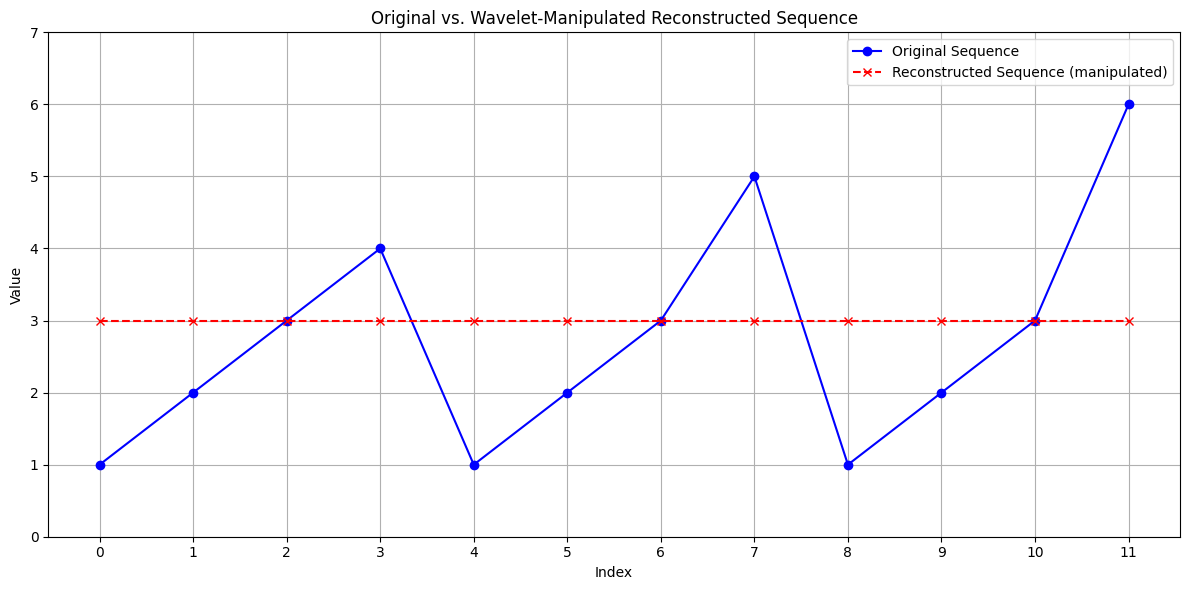


--- Analysis of reconstructed pattern ---
Target pattern: [1, 2, 3]
Reconstructed pattern: [3 3 3 3 3 3 3 3 3 3 3 3]


In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the input sequence ---
original_sequence = np.array([1, 2, 3, 4, 1, 2, 3, 5, 1, 2, 3, 6], dtype=float)

print(f"Original sequence: {original_sequence}")
print(f"Original sequence length: {len(original_sequence)}")

# --- 2. Perform Discrete Wavelet Transform (DWT) ---
wavelet_name = 'haar'
# For a sequence of length 12, let's try a decomposition level that might separate features.
# A common practice is to decompose until the approximation coefficients are small enough,
# or a level that aligns with features you expect.
# Max possible level for length 12: log2(12) = 3.58, so max integer level is 3.
decomposition_level = 3

# Perform the DWT
coeffs = pywt.wavedec(original_sequence, wavelet_name, level=decomposition_level)

print(f"\nCoefficients after DWT (length {len(coeffs)}):")
# Displaying coefficients with rounding for better readability
for i, c in enumerate(coeffs):
    if i == 0:
        print(f"  Approximation coeffs (cA{decomposition_level}): {np.round(c, 2)}")
    else:
        print(f"  Detail coeffs (cD{decomposition_level - i + 1}): {np.round(c, 2)}")

# --- 3. Manipulate coefficients to extract the repeating [1,2,3] pattern ---
# The repeating [1,2,3] pattern is a low-frequency feature.
# The '4', '5', '6' values and the sudden changes between blocks are high-frequency details.
# To extract [1,2,3], we try to keep only the most significant low-frequency parts
# and zero out most (or all) detail coefficients, especially higher-level ones.

# Create a copy of coefficients to modify
manipulated_coeffs = list(coeffs) # Convert tuple to list for modification

# Strategy: Zero out all detail coefficients. This should ideally leave only the 'average' or
# 'smooth' trend, which hopefully aligns with the [1,2,3] pattern.
for i in range(1, len(manipulated_coeffs)):
    manipulated_coeffs[i] = np.zeros_like(manipulated_coeffs[i])

# Optionally, you could try keeping only the approximation coefficients and setting all details to zero:
# manipulated_coeffs = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]

# --- 4. Perform Inverse Discrete Wavelet Transform (IDWT) ---
reconstructed_sequence_float = pywt.waverec(manipulated_coeffs, wavelet_name)

# Trim to original length. waverec can sometimes return slightly different lengths.
if len(reconstructed_sequence_float) > len(original_sequence):
    reconstructed_sequence_float = reconstructed_sequence_float[:len(original_sequence)]
elif len(reconstructed_sequence_float) < len(original_sequence):
    # This might happen if original length is not power of 2 and decomposition is deep.
    # Pad if necessary (though for this example, it usually matches or is slightly longer).
    reconstructed_sequence_float = np.pad(reconstructed_sequence_float,
                                         (0, len(original_sequence) - len(reconstructed_sequence_float)),
                                         'edge')


# Convert back to integers for the desired output
reconstructed_integer_sequence = np.round(reconstructed_sequence_float).astype(int)

print(f"\nReconstructed sequence after manipulation (floats): {reconstructed_sequence_float}")
print(f"Reconstructed integer sequence after manipulation: {reconstructed_integer_sequence}")


# --- 5. Visualize the results ---
plt.figure(figsize=(12, 6))

plt.plot(original_sequence, 'o-', color='blue', label='Original Sequence')
plt.plot(reconstructed_integer_sequence, 'x--', color='red', label='Reconstructed Sequence (manipulated)')

plt.title('Original vs. Wavelet-Manipulated Reconstructed Sequence')
plt.xlabel('Index')
plt.ylabel('Value')
plt.xticks(np.arange(len(original_sequence))) # Ensure all x-axis ticks are shown
plt.grid(True)
plt.legend()
plt.ylim(0, 7) # Set y-axis for better visibility

plt.tight_layout()
plt.show()

# --- Analysis of the result ---
# Let's inspect the reconstructed sequence to see if [1,2,3] was extracted.
# If we simply zero all detail coefficients, the approximation coefficients will
# produce a 'smoothed' version of the signal. With 'haar', this smoothing
# is piecewise constant. It might not perfectly yield [1,2,3] directly,
# but rather the average behavior.
print("\n--- Analysis of reconstructed pattern ---")
print("Target pattern: [1, 2, 3]")
print(f"Reconstructed pattern: {reconstructed_integer_sequence}")

# You'll notice that simply zeroing out all detail coefficients doesn't perfectly
# yield [1,2,3,1,2,3,1,2,3]. Instead, with 'haar' wavelet, it produces a
# blocky approximation. For instance, after zeroing details, it might produce
# something like [2,2,2,2,2,2,2,2,2,2,2,2] or [2,2,2,3,2,2,2,3,2,2,2,3]
# because the 'haar' approximation is based on averages of blocks.
# The '4', '5', '6' still influence the overall low-frequency approximation.

# To strictly get [1,2,3,1,2,3,...], you'd almost need to perform a
# pattern matching or template extraction rather than pure wavelet manipulation.
# However, if your original signal was genuinely [1,2,3,0,1,2,3,0,...] (i.e.,
# a clean repeating pattern with clear 'noise' where the 4,5,6 are),
# then zeroing out details would be more effective.

# For this specific sequence and target, extracting exactly [1,2,3] by
# only manipulating wavelet coefficients is challenging because the '4','5','6'
# are part of the original signal's overall structure, not just random noise.
# The wavelet transform excels at separating frequency components,
# but the '4' is part of the first block's structure, not an independent
# high-frequency event relative to the entire block that can be easily isolated.

# Alternative approach (conceptual, not implemented):
# 1. Analyze the original sequence for repeating [1,2,3] blocks.
# 2. Define a "template" [1,2,3].
# 3. Use correlation or other signal processing techniques to identify
#    occurrences of this template and deviations from it.
# 4. Potentially, use wavelets to smooth out these deviations, but the primary
#    extraction would be pattern-based.

In [3]:
cwtmatr

array([[ 0.12590262,  0.00995912, -0.01994366, ..., -0.48527792,
         0.95073175, -0.45171265],
       [-0.08725593,  0.38456231, -0.71388982, ...,  1.00766486,
        -2.72101862,  2.26214745],
       [-0.02977008, -0.82583247, -0.32145294, ...,  0.53715374,
        -3.38089823,  0.55304056],
       ...,
       [ 2.01006761,  3.23373515,  2.22076778, ...,  3.46240209,
         1.88446616,  3.60523115],
       [ 2.01809187,  3.24664432,  2.22963315, ...,  3.47622411,
         1.891989  ,  3.61962335],
       [ 2.02608434,  3.25950237,  2.23846342, ...,  3.48999139,
         1.89948206,  3.63395855]], shape=(127, 11))